<a href="https://colab.research.google.com/github/AlexFeeney/Project4_Group3/blob/main/Kmeans_PCA_240319.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Create a working environment

!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
!pip install hvplot
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recov

In [6]:
# Import packages

import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import DataFrame, SparkSession
import time
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
# Create a SparkSession

spark= SparkSession \
       .builder \
       .appName("Project 4 Group 3 Spark") \
       .getOrCreate()
spark

# Read in data

In [8]:
# Read in data from Github as a DataFrame.
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/AlexFeeney/Project4_Group3/main/Data/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

# Preprocessing data

In [9]:
# Convert DataFrame to Pandas DataFrame
pandas_df = df.toPandas()


In [10]:
# Determine the number of unique values in each column.
pandas_df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   419
smoking_status          4
stroke                  2
dtype: int64

In [11]:
# Count unique values in column 'gender'
pandas_df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
# Conditionally drop rows where column 'gender' contains the text 'Other'
pandas_df_clean = pandas_df[~pandas_df['gender'].str.contains('Other')]

pandas_df_clean['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [13]:
# Conditionally drop rows where column 'bmi' contains the text 'N/A'
pandas_df_clean = pandas_df_clean[~pandas_df_clean['bmi'].str.contains('N/A')]

pandas_df_clean['gender'].value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

In [14]:
# Drop the non-beneficial 'id' columns
pandas_df_clean = pandas_df_clean.drop(columns = ['id'])
pandas_df_clean.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
5,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1


In [15]:
# Check data types of columns
print(pandas_df_clean.dtypes)

gender               object
age                  object
hypertension         object
heart_disease        object
ever_married         object
work_type            object
Residence_type       object
avg_glucose_level    object
bmi                  object
smoking_status       object
stroke               object
dtype: object


In [16]:
# Create dummy data for the categorical features
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

pandas_df_clean_numeric = pd.get_dummies(pandas_df_clean, columns=categorical_cols, dtype=int)

pandas_df_clean_numeric

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228.69,36.6,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,80,0,1,105.92,32.5,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,49,0,0,171.23,34.4,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,79,1,0,174.12,24,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
5,81,0,0,186.21,29,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13,0,0,103.08,18.6,0,1,0,1,0,...,0,0,0,1,1,0,1,0,0,0
5106,81,0,0,125.2,40,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0
5107,35,0,0,82.99,30.6,0,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
5108,51,0,0,166.29,25.6,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


# Normalizing data

In [17]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
pandas_df_clean_numeric_scaled = StandardScaler().fit_transform(
    pandas_df_clean_numeric[["age","avg_glucose_level","bmi"]]
)

# Review the data
pandas_df_clean_numeric_scaled

array([[ 1.06993757,  2.77779723,  0.98114481],
       [ 1.64633634,  0.01401584,  0.45908589],
       [ 0.27184695,  1.48426559,  0.70101563],
       ...,
       [-0.34889019, -0.50218118,  0.21715615],
       [ 0.36052369,  1.37305699, -0.41950107],
       [ 0.05015511, -0.45062901, -0.3431022 ]])

In [18]:
# Create a DataFrame of the scaled data
pandas_df_clean_numeric_scaled = pd.DataFrame(pandas_df_clean_numeric_scaled, columns=["age","avg_glucose_level","bmi"])

# Replace the original data with the columns of information from the scaled Data
pandas_df_clean_numeric["age"] = pandas_df_clean_numeric_scaled["age"]
pandas_df_clean_numeric["avg_glucose_level"] = pandas_df_clean_numeric_scaled["avg_glucose_level"]
pandas_df_clean_numeric["bmi"] = pandas_df_clean_numeric_scaled["bmi"]

# Review the DataFrame
pandas_df_clean_numeric

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,0,1,2.777797,0.981145,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,0.271847,0,1,1.484266,0.701016,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,1.601998,0,0,1.549325,-0.623231,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,1.690675,1,0,1.821493,0.013426,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
5,1.380306,0,0,-0.792584,-0.190304,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,NaN,0,0,NaN,NaN,0,1,0,1,0,...,0,0,0,1,1,0,1,0,0,0
5106,NaN,0,0,NaN,NaN,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0
5107,NaN,0,0,NaN,NaN,0,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
5108,NaN,0,0,NaN,NaN,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


In [19]:
# Remove the "NaN" containing rows
pandas_df_clean_numeric = pandas_df_clean_numeric.dropna()
pandas_df_clean_numeric

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,0,1,2.777797,0.981145,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,0.271847,0,1,1.484266,0.701016,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,1.601998,0,0,1.549325,-0.623231,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,1.690675,1,0,1.821493,0.013426,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
5,1.380306,0,0,-0.792584,-0.190304,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,-1.324334,0,0,-0.049918,-1.310821,0,1,0,1,0,...,0,1,0,0,1,0,1,0,0,0
4904,1.690675,0,0,0.448045,1.414072,0,1,0,1,0,...,0,0,0,1,1,0,1,0,0,0
4905,-0.348890,0,0,-0.502181,0.217156,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
4906,0.360524,0,0,1.373057,-0.419501,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [20]:
# Remove the "stroke" column
pandas_df_clean_numeric_nolabel = pandas_df_clean_numeric.drop("stroke", axis=1)
pandas_df_clean_numeric_nolabel

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.069938,0,1,2.777797,0.981145,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0
2,0.271847,0,1,1.484266,0.701016,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,1.601998,0,0,1.549325,-0.623231,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,1.690675,1,0,1.821493,0.013426,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
5,1.380306,0,0,-0.792584,-0.190304,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,-1.324334,0,0,-0.049918,-1.310821,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0
4904,1.690675,0,0,0.448045,1.414072,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0
4905,-0.348890,0,0,-0.502181,0.217156,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4906,0.360524,0,0,1.373057,-0.419501,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


# Data clustering using with K-means Using the PCA data

In [25]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

In [30]:
# Use the PCA model with `fit_transform` to reduce to three principal components.
pandas_df_clean_numeric_nolabel_pca = pca.fit_transform(pandas_df_clean_numeric_nolabel)

# View the first five rows of the DataFrame.
pandas_df_clean_numeric_nolabel_pca[:5]

array([[ 2.6565059 , -1.6538114 ,  0.26004068],
       [ 1.34665343, -0.88418183,  0.37405093],
       [ 1.4081998 , -1.25001962, -1.32571703],
       [ 1.99711259, -1.18598945, -1.04094108],
       [ 0.38042946,  0.90377461, -1.29289979]])

In [31]:
# Retrieve the explained variance to determine how much information can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.25359777, 0.14202265, 0.11197949])

In [32]:
# Total explained variance of the three principal components
0.25359777+0.14202265+0.11197949

0.5075999099999999

In [33]:
# Create a new DataFrame with the PCA data.

# Creating a DataFrame with the PCA data
pandas_df_clean_numeric_nolabel_pca_df = pd.DataFrame(
    pandas_df_clean_numeric_nolabel_pca,
    columns=["PCA1", "PCA2", "PCA3"]
)

# Copy the "stroke" column from the pandas_df_clean_numeric
pandas_df_clean_numeric_nolabel_pca_df["stroke"] = pandas_df_clean_numeric["stroke"]

# Set the "stroke" column as index
pandas_df_clean_numeric_nolabel_pca_df = pandas_df_clean_numeric_nolabel_pca_df.set_index("stroke")

# Display sample data
pandas_df_clean_numeric_nolabel_pca_df.head()

,PCA1,PCA2,PCA3
stroke,,,
1,2.656506,-1.653811,0.260041
NaN,1.346653,-0.884182,0.374051
1,1.408200,-1.250020,-1.325717
1,1.997113,-1.185989,-1.040941
1,0.380429,0.903775,-1.292900


In [37]:
# Initialise the K-Means model using k = 2
model = KMeans(n_clusters=2, random_state=0)

In [38]:
# Fit the K-Means model using the PCA data
model.fit(pandas_df_clean_numeric_nolabel_pca_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [39]:
# Predict the clusters using the PCA data
k_2 = model.predict(pandas_df_clean_numeric_nolabel_pca_df)

# Print the resulting array of cluster values.
print(k_2)

[0 0 0 ... 1 0 1]


In [40]:
# Create a copy of the DataFrame with the PCA data
pca_df = pandas_df_clean_numeric_nolabel_pca_df.copy()

# Add a new column to the DataFrame with the predicted clusters
pca_df["predicted_cluster"] = k_2

# Display sample data
pca_df.head(5)

,PCA1,PCA2,PCA3,predicted_cluster
stroke,,,,
1,2.656506,-1.653811,0.260041,0
NaN,1.346653,-0.884182,0.374051,0
1,1.408200,-1.250020,-1.325717,0
1,1.997113,-1.185989,-1.040941,0
1,0.380429,0.903775,-1.292900,0


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
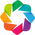

:NdOverlay   [predicted_cluster]
   :Scatter   [PCA1]   (PCA2,stroke)

In [47]:
import holoviews as hv
hv.extension('bokeh')

# Create a scatter plot using hvPlot by setting
# `x="PC1"` and `y="PC2"`.
# Colour the graph points with the labels found using K-Means and
# add the stroke label in the `hover_cols` parameter to identify
# the stroke recorded in each data point.
cluster_pca_plot = pca_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="predicted_cluster",
    hover_cols="stroke"
)

cluster_pca_plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
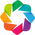

:NdOverlay   [stroke]
   :Scatter   [PCA1]   (PCA2,stroke)

In [48]:
import holoviews as hv
hv.extension('bokeh')

# Create a scatter plot using hvPlot by setting
# `x="PC1"` and `y="PC2"`.
# Colour the graph points with the labels found using K-Means and
# add the stroke label in the `hover_cols` parameter to identify
# the stroke recorded in each data point.
cluster_pca_plot = pca_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="stroke",
    hover_cols="stroke"
)

cluster_pca_plot